# Analysis on nominations dataset

The aim of this notebook is an exploratory analysis of the nominations dataset

Exploratory analisis the following objectives:
1. Apply feature engineering to data (feature extraction and selection)
2. Describe data and search for possible segmentations about demands and abilities of applicants

## Feature engineering

The aim of this step is to develop useful features that may help us to describe the data and ultimately get insights about a possible segmentation of the data with regard to demands and abilities of the applicants.

### Load data

In [51]:
import pandas as pd

In [58]:
df = pd.read_csv('../data/training_data.csv', sep=';')
df.rename(columns={'Sentencias':'sentence'}, inplace=True)

In [59]:
df.sentence = df.sentence.str.strip()

In [60]:
df.sentence

0       Our special guest this morning as we have our ...
1       I don't have much of a statement to make prior...
2       I include my statement in the record and yield...
3       We appreciate your coming this morning and you...
4       I'm very pleased to be here to indicate my ver...
5       During her tenure there, she's chaired the Com...
6       She's been the Commission's lead representativ...
7       She's currently a member of the National Assoc...
8       The Committee knows well that she's been an ac...
9       She's worked hard to promote the advancement o...
10      She's played a key role in shaping policies fo...
11      She's credited with helping to forge a consens...
12      She's worked tirelessly to facilitate delivery...
13      She had a very distinguished record before com...
14      She has been a senior lender to communication ...
15      She has been a very active leader in our commu...
16      She has done I think a terrific job in handlin...
17      I thin

### Distribution

Take a look at the distribution of the dataset

In [61]:
import seaborn as sns

%matplotlib inline

       count  pencentage
label                   
D       1001    0.129362
N       6737    0.870638


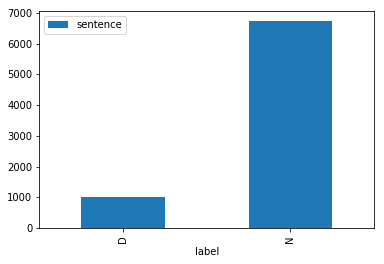

In [62]:
df_label_counts = df.groupby(['label']).count()

result = pd.concat([df_label_counts, df_label_counts.apply(lambda x: x/x.sum())], axis =1)
result.columns = ['count', 'pencentage']
print(result)

df_label_counts.plot(kind='bar')

Our dataset has an *asymetric distribution*

## Feature engineering

The dataset is mostly natural language. This step involves the application of Natural Language Processing to extract useful data from the *sentences* of the nominations dataset.

Each row of the dataset is already a sentence, so sentence split is unnecesary.

The NLP pipeline for the sentences dataset involves:
1. Remove punctuation and stopwords
2. Tokenization (1 to 3 ngrams)

### NLP Pipeline

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

The docs of the sklearn tfidfvectorizer state the following:

<cite>
class sklearn.feature_extraction.text.TfidfVectorizer(input=’content’, encoding=’utf-8’, decode_error=’strict’, strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer=’word’, stop_words=None, token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.float64’>, norm=’l2’, use_idf=True, smooth_idf=True, sublinear_tf=False)[source]¶
</cite>

We start with a simple approach by producing 1-grams

In [64]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(1,1))

In [65]:
vec_fit = vec.fit_transform(df.sentence)

In [66]:
len(vec.get_feature_names())

10839

In [67]:
# Index of 'D' labeled documents
idx_D_labeled = df.label[df.label == 'D'].index.tolist()

#features of the 'D' labeled documents
vec_fit[idx_D_labeled, :]

<1001x10839 sparse matrix of type '<class 'numpy.float64'>'
	with 24367 stored elements in Compressed Sparse Row format>

Now, take a look at the frequencies of the features in the whole dataset

In [68]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

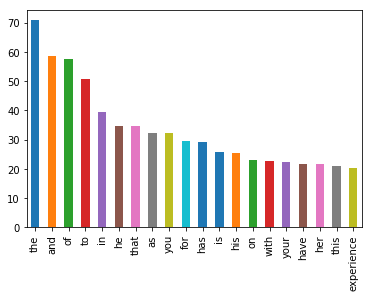

In [69]:
features_tfidf.sort_values(ascending=False)[:20].plot(kind='bar')

The dataset shows a high dimensionality and the top 20 tfidf features are mostly stopwords.

### Add stopwords

In [70]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(1,1), stop_words='english')

vec_fit = vec.fit_transform(df.sentence)

In [71]:
len(vec.get_feature_names())

10559

Now, take a look at the frequencies of the features in the whole dataset

In [72]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

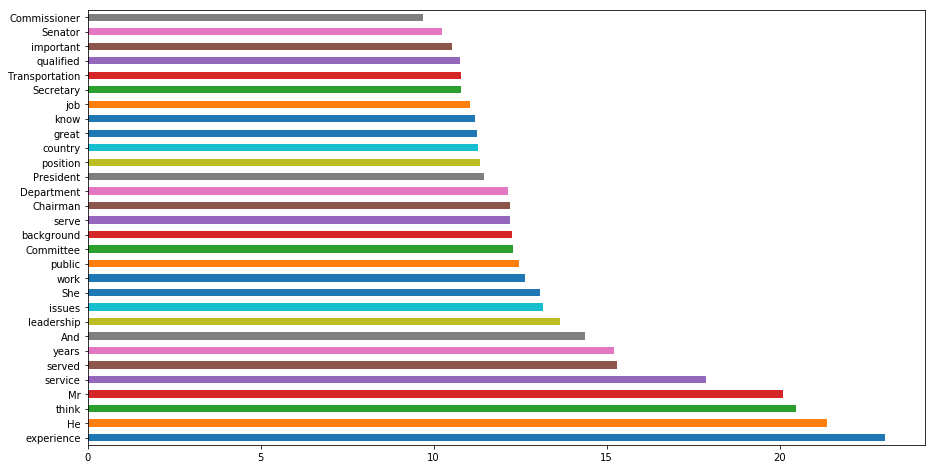

In [73]:
features_tfidf.sort_values(ascending=False)[:30].plot(kind='barh', figsize=(15,8))

### Ngram n=(2,4)

In [74]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(2,4), stop_words='english')

vec_fit = vec.fit_transform(df.sentence)

In [75]:
len(vec.get_feature_names())

234416

Now, take a look at the frequencies of the features in the whole dataset

In [76]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

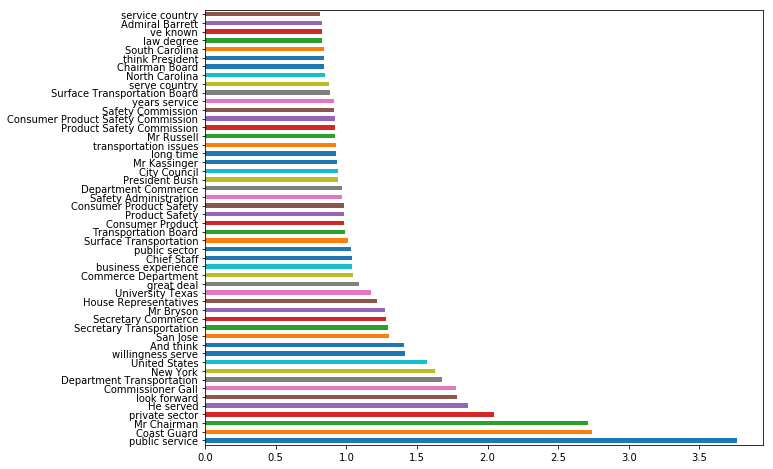

In [77]:
features_tfidf.sort_values(ascending=False)[:50].plot(kind='barh', figsize=(10,8))

There are many names for locations and persons that we could replace with other representative tokens such as LOCATION, ROLE, and NAME.

Next step is to use Name Entity Recognition

### Name Entity Recognition

In [78]:
import textacy

We start by identifying some **keywords** in context. 

The first keyword is 'expertise'

In [79]:
for sent in df.sentence:
    textacy.text_utils.KWIC(sent, keyword='expertise', window_width=35)

and they bring a certain amount of  expertise  to government that we certainly ne
e that you bring a broad range and  expertise  to the position for which you have
dentials and the knowledge and the  expertise  that is consistent with the post. 
Ms. Victory gained a great deal of  expertise  in wireless and satellite issues, 
ittee and brings to this Committee  expertise  in areas such as space and insuran
he state of Florida has caused his  expertise  to be sought out around the countr
an testify as to the character and  expertise  of an individual.                 
nk almost 20 years, he also has an  expertise  in the private sector.            
 increase and a lot of all of this  expertise  had been laid off in the process, 
mean a considerable layoff of that  expertise  and then when the time comes and i
, and you do not have the critical  expertise  in the Department to analyze these
 individual with his technological  expertise  as one of the leaders in the Offic
d in particular 

Another keyword may be 'he/she has'

In [80]:
for sent in df.sentence:
    textacy.text_utils.KWIC(sent, keyword='he has ', window_width=35)

                                  S he has  been a senior lender to communicati
                                  S he has  been a very active leader in our co
                                  S he has  done I think a terrific job in hand
at the Federal/State Joint Board, s he has  represented us in World Radio Commu
  I applaud her for the work that s he has  done, particularly in the area in u
                                    He has  the knowledge, he has the legislati
             He has the knowledge,  he has  the legislative background, he has 
he has the legislative background,  he has  the experience, and he has the abil
ground, he has the experience, and  he has  the ability, I think, to be a very 
member in a biological sense, but s he has  Mr. Chris Hart who is a member of t
                    For her part, s he has  been willing to change her views af
ng time and I appreciate the work s he has  done and the service she has given 
work she has done and the service s he h

### Corpus

Now, create a **Corpus** containing the **Doc** structures for our text. This may take a few minutes, depending on your hardware.

In [81]:
en = textacy.load_spacy('../data/en_core_web_md/en_core_web_md-2.0.0')#spacy.load('en_core_web_md')

In [82]:
corpus = textacy.Corpus(lang='../data/en_core_web_md/en_core_web_md-2.0.0', texts=df.sentence.tolist())
corpus

Corpus(7738 docs; 257978 tokens)

In [83]:
vectorizer = textacy.Vectorizer( tf_type='sqrt', apply_idf=True, idf_type='smooth', norm='l2',\
                                min_df=2, max_df=0.95
                               )

In [84]:
doc_term_matrix = vectorizer.fit_transform((doc.to_terms_list(ngrams=(2,3), named_entities=True, as_strings=True) \
                                            for doc in corpus))

In [85]:
print(repr(doc_term_matrix))

<7738x40056 sparse matrix of type '<class 'numpy.float64'>'
	with 256006 stored elements in Compressed Sparse Row format>


Let's plot the data

In [86]:
features_tfidf = pd.Series(doc_term_matrix[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vectorizer.vocabulary_terms.keys())

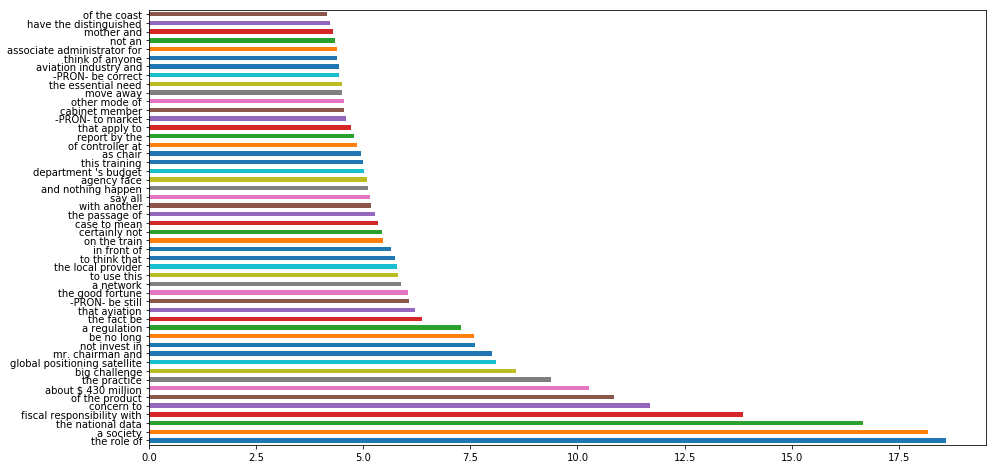

In [87]:
features_tfidf.sort_values(ascending=False)[:50].plot(kind='barh', figsize=(15,8))

Let's get a **topic model** for this dataset

In [88]:
model = textacy.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

(7738, 10)

In [89]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : -PRON- be   of the   that -PRON-   and -PRON-   be a   in the   of -PRON-   and -PRON- be   that be   that -PRON- be
topic 1 : go to   be go   be go to   -PRON- be go   go to be   to be   -PRON- be   go to have   to have   to have to
topic 2 : look forward   look forward to   forward to   -PRON- look forward   -PRON- look   work with   work with -PRON-   to work with   to work   with -PRON-
topic 3 : do not   -PRON- do   -PRON- do not   do not have   not have   and -PRON- do   do not think   not think   but -PRON-   not want
topic 4 : would like   -PRON- would like   -PRON- would   like to   would like to   and -PRON- would   like to know   but -PRON- would   to know   if -PRON-
topic 5 : -PRON- think   think -PRON-   -PRON- think -PRON-   think -PRON- be   and -PRON- think   think -PRON- have   -PRON- think that   do -PRON- think   and -PRON-   think that
topic 6 : -PRON- will   -PRON- hope   that -PRON- will   hope that   will be   -PRON- will be   hope that -PRON-   -PRON-

### Replaces locations, roles and names

In [90]:
import nltk

In [91]:
grammar = ('''
    NP: {<DT>?<JJ>*<NN>} # NP
    ''')

In [92]:
chunkParser = nltk.RegexpParser(grammar)
tagged = nltk.pos_tag(nltk.word_tokenize(df.sentence[0]))
#tagged
tree = chunkParser.parse(tagged)
#tree

In [93]:
tree.leaves()

[('Our', 'PRP$'),
 ('special', 'JJ'),
 ('guest', 'NN'),
 ('this', 'DT'),
 ('morning', 'NN'),
 ('as', 'IN'),
 ('we', 'PRP'),
 ('have', 'VBP'),
 ('our', 'PRP$'),
 ('first', 'JJ'),
 ('hearing', 'NN'),
 ('or', 'CC'),
 ('the', 'DT'),
 ('hearing', 'NN'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('reappointment', 'NN'),
 ('of', 'IN'),
 ('Ms.', 'NNP'),
 ('Ness', 'NNP'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('Federal', 'NNP'),
 ('Communications', 'NNPS'),
 ('Commission', 'NNP'),
 ('.', '.')]

In [94]:
patt = r'<DET>? (<NOUN>+ <ADP|CONJ>)* <NOUN>+'

for chunk in textacy.extract.pos_regex_matches(corpus[0], patt):
    print(chunk)

guest
this morning
hearing
the hearing
the reappointment


Let's try a different approach

Now, we are going to apply nltk to extract labels of noun phrases [Ref](https://www.commonlounge.com/discussion/2662a77ddcde4102a16d5eb6fa2eff1e)

In [95]:
## Snippet source:
## https://www.commonlounge.com/discussion/2662a77ddcde4102a16d5eb6fa2eff1e

import nltk

result = []

for sent in df.sentence:
    # tokenize doc
    tokenized_doc = nltk.word_tokenize(sent)

    # tag sentences and use nltk's Named Entity Chunker
    tagged_sentences = nltk.pos_tag(tokenized_doc)
    ne_chunked_sents = nltk.ne_chunk(tagged_sentences)

    # extract all named entities
    named_entities = []
    for tagged_tree in ne_chunked_sents:
        if hasattr(tagged_tree, 'label'):
            entity_name = ' '.join(c[0] for c in tagged_tree.leaves()) #
            entity_type = tagged_tree.label() # get NE category
            named_entities.append((entity_name, entity_type))
    
    result.append(named_entities)


In [96]:
flat_list = [pair for line in result for pair in line]

In [97]:
df_ner = pd.DataFrame(flat_list, columns=['name', 'label'])

In [98]:
df_ner = df_ner.sort_values(['name', 'label']).drop_duplicates()

In [99]:
df_ner

,name,label
3804,A380,ORGANIZATION
4833,AASHTO,ORGANIZATION
5670,ADOT,ORGANIZATION
3341,AFSCME,ORGANIZATION
5775,AMT,ORGANIZATION
7026,ANSI,ORGANIZATION
3694,ANWR,ORGANIZATION
170,AOL,ORGANIZATION
4653,APL,ORGANIZATION
1524,ATF,ORGANIZATION


What are the unique labels?

In [101]:
df_ner.label.unique()

array(['ORGANIZATION', 'GPE', 'PERSON', 'GSP', 'FACILITY', 'LOCATION'],
      dtype=object)

In [102]:
df_ner.shape

(2516, 2)

In [103]:
len(df_ner.name.unique())

2273